# Bayesian Gaussian Mixture Model and Hamiltonian MCMC

In this colab we'll explore sampling from the posterior of a Bayesian Gaussian Mixture Model (BGMM) using only Tensorflow Probability primitives. 

## Model

For $k\in\{1,\ldots, K\}$ mixture components each of dimension $D$, we'd like to model $i\in\{1,\ldots,N\}$ iid samples using the following Bayesian Gaussian Mixture Model:

$$\begin{align*}
\theta &\sim \text{Dirichlet}(\text{concentration}=\alpha_0) \\
\mu_k &\sim \text{Normal}(\text{loc}=\mu_{0k}, \text{scale}=I_D) \\
T_k &\sim \text{Wishart}(\text{df}=5, \text{scale}=I_D) \\
Z_i &\sim \text{Categorical}(\text{probs}=\theta) \\
Y_i &\sim \text{Normal}(\text{loc}=\mu_{z_i}, \text{scale}=T_{z_i}^{-1/2})\\
\end{align*}$$

Note, the `scale` arguments all have `cholesky` semantics. We use this convention because it is that of TF Distributions (which itself uses this convention in part because it is computationally advantageous). 

Our goal is to generate samples from the posterior:

$$p\left(\theta, \{\mu_k, T_k\}_{k=1}^K \Big| \{y_i\}_{i=1}^N, \alpha_0, \{\mu_{ok}\}_{k=1}^K\right)$$

Notice that $\{Z_i\}_{i=1}^N$ is not present--we're interested in only those random variables which don't scale with $N$.  (And luckily there's a TF distribution which handles marginalizing out $Z_i$.)

It is not possible to directly sample from this distribution owing to a computationally intractable normalization term. 

[Metropolis-Hastings algorithms](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) are technique for for sampling from intractable-to-normalize distributions.

Tensorflow Probability offers a number of MCMC options, including several based on Metropolis-Hastings. In this notebook, we'll use [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)  (`tfp.mcmc.HamiltonianMonteCarlo`). HMC is often a good choice because it can converge rapidly, samples the state space jointly (as opposed to coordinatewise), and leverages one of TF's virtues: automatic differentiation. That said, fitting a BGMM might actually be better served by other approaches, e.g., [Gibb's sampling](https://en.wikipedia.org/wiki/Gibbs_sampling).

In [0]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow_probability as tfp
import tensorflow as tf 

from tensorflow.python.ops.distributions import util as distribution_util

tfd = tfp.distributions
tfb = tfp.distributions.bijectors

In [0]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

reset_sess()

Before actually building the model, we'll need to define a new type of distribution.  From the model specification above, its clear we're parameterizing the MVN with an inverse covariance matrix, i.e.,  [precision matrix](https://en.wikipedia.org/wiki/Precision_(statistics%29).  To accomplish this in TF,  we'll use the transformation `tfb.Invert(tfb.Affine(...))`. In so doing the `log_prob` calculation uses [`tf.matmul`](https://www.tensorflow.org/api_docs/python/tf/matmul) instead of [`tf.linalg.triangular_solve`](https://www.tensorflow.org/api_docs/python/tf/matrix_triangular_solve) (as would be the case for `tfd.MultivariateNormalTriL`). Aside from this being arguably more interprettable, using `tf.matmul` is advantageous since it is usually faster owing to better cache locality.

In [0]:
class MVNInverseTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, precision_tril, name=None):
    super(MVNInverseTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(loc, scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Invert(tfb.Affine(scale_tril=precision_tril)),
        name=name)

The `tfd.Independent` distribution turns independent draws of one distribution, into a multivariate distribution with statistically independent coordinates. In terms of computing `log_prob`, this "meta-distribution" manifests as a simple sum over the event dimension(s).

Using the above definition, specifying the random variables is relatively easy.

In [0]:
dtype = np.float32
dims = 2
components = 3

In [0]:
rv_mix_probs = tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.,
    name='rv_mix_probs')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')

rv_precision = tfd.WishartCholesky(
    df=5,
    scale=np.stack([np.eye(dims, dtype=dtype)]*components),
    cholesky_input_output_matrices=True,
    name='rv_precision')

In [0]:
print(rv_mix_probs)
print(rv_loc)
print(rv_precision)

tf.distributions.Dirichlet("rv_mix_probs/", batch_shape=(), event_shape=(3,), dtype=float32)
tf.distributions.Independent("rv_loc/", batch_shape=(3,), event_shape=(2,), dtype=float32)
tf.distributions.WishartCholesky("rv_precision/", batch_shape=(3,), event_shape=(2, 2), dtype=float32)


Using the three random variables defined above, we can now specify the joint log probability function. To do this we'll use `tfd.MixtureSameFamily` to automatically integrate out the categorical $\{Z_i\}_{i=1}^N$ draws.

In [0]:
def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `SoftmaxInverse(Dirichlet)` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  rv_observations = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNInverseTriL(
          loc=loc,
          precision_tril=chol_precision))
  log_prob_parts = [
      rv_observations.log_prob(observations), # Sum over samples.
      rv_mix_probs.log_prob(mix_probs)[..., tf.newaxis], 
      rv_loc.log_prob(loc),                   # Sum over components.
      rv_precision.log_prob(chol_precision),  # Sum over components.
  ]
  sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)
  # Note: for easy debugging, uncomment the following:
  # sum_log_prob = tf.Print(sum_log_prob, log_prob_parts)
  return sum_log_prob

Notice that this function internally defines a new random variable. This is necessary since the `observations` RV depends on samples from the RVs defined further above.

## Generate "Training" Data

For this demo, we'll sample some random data.

In [0]:
num_samples = 1000
true_loc = np.array([[-2, -2],
                     [0, 0],
                     [2, 2]], dtype)
random = np.random.RandomState(seed=42)

true_hidden_component = random.randint(0, components, num_samples)
observations = (true_loc[true_hidden_component] +
                random.randn(num_samples, dims).astype(dtype))

## Bayesian Inference using HMC

Now that we've used TFD to specify our model and obtained some observed data, we have all the necessary pieces to run HMC.

To do this, we'll use a [closure](https://en.wikipedia.org/wiki/Closure_(computer_programming%29#Anonymous_functions) to "pin down" the things we don't want to sample. In this case that means we need only pin down `observations`. (The hyper-parameters are already baked in to the prior distributions and not part of the `joint_log_prob` function signature.)

In [0]:
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(observations, *args)

In [0]:
initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2, -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

### Unconstrained Representation

Hamiltonian Monte Carlo (HMC) requires the target log-probability function be differentiable with respect to its arguments.  Furthermore, HMC can exhibit dramatically higher statistical efficiency if the state-space is unconstrained.

This means we'll have to work out two main issues when sampling from the BGMM posterior:

1. $\theta$ represents a discrete probability vector, i.e., must be such that $\sum_{k=1}^K \theta_k = 1$ and $\theta_k>0$.
2. $T_k$ represents an inverse covariance matrix, i.e., must be such that $T_k \succ 0$, i.e., is [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix).


To address this requirement we'll need to:

1. transform the constrained variables to an unconstrained space
2. run the MCMC in unconstrained space
3. transform the unconstrained variables back to the constrained space.

As with `MVNInverseTriL`, we'll use [`Bijector`s](https://www.tensorflow.org/api_docs/python/tf/distributions/bijectors/Bijector) to transform random variables to unconstrained space.

- The [`Dirichlet`](https://en.wikipedia.org/wiki/Dirichlet_distribution) is transformed to unconstrained space via the [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

- Our precision random variable is a distribution over postive semidefinite matrices. To unconstrain these we'll use the `FillTriangular` and `TransformDiagonal` bijectors.  These convert vectors to lower-triangular matrices and ensure the diagonal is positive. The former is useful because it enables sampling only $d(d+1)/2$ floats rather than $d^2$.

In [0]:
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

In [0]:
[mix_probs, loc, chol_precision], kernel_results = tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_posterior_log_prob,
            step_size=0.03,
            num_leapfrog_steps=5),
        bijector=unconstraining_bijectors))

In [0]:
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.inner_results.is_accepted))
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0)
mean_loc = tf.reduce_mean(loc, axis=0)
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0)

Note: we've already tuned the `step_size` and `num_leapfrog_steps` to approximately achieve an [asymptotically optimal rate of 0.651](https://arxiv.org/abs/1001.4460).

We'll now execute the chain and print the posterior means.

In [0]:
[
    acceptance_rate_,
    mean_mix_probs_,
    mean_loc_,
    mean_chol_precision_,
    mix_probs_,
    loc_,
    chol_precision_,
] = sess.run([
    acceptance_rate,
    mean_mix_probs,
    mean_loc,
    mean_chol_precision,
    mix_probs,
    loc,
    chol_precision,
])

In [0]:
print('    acceptance_rate:', acceptance_rate_)
print('      avg mix probs:', mean_mix_probs_)
print('\n            avg loc:\n', mean_loc_)
print('\navg chol(precision):\n', mean_chol_precision_)

    acceptance_rate: 0.641
      avg mix probs: [ 0.39652753  0.23796532  0.36550719]

            avg loc:
 [[-1.85150051 -1.58520997]
 [-0.01392753  0.01626917]
 [ 1.81968725  1.59268594]]

avg chol(precision):
 [[[ 0.99440396  0.        ]
  [-0.07709358  0.96896082]]

 [[ 1.21073735  0.        ]
  [ 0.31398559  1.11340523]]

 [[ 0.96760911  0.        ]
  [-0.13563943  0.96555084]]]


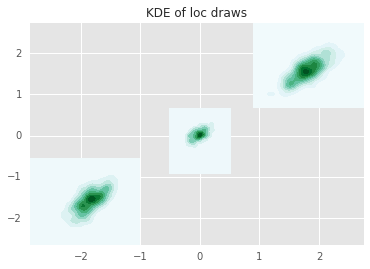

In [0]:
ax = sns.kdeplot(loc_[:,0,0], loc_[:,0,1], shade=True)
ax = sns.kdeplot(loc_[:,1,0], loc_[:,1,1], shade=True)
ax = sns.kdeplot(loc_[:,2,0], loc_[:,2,1], shade=True)
plt.title('KDE of loc draws');

## Conclusion

This simple colab demonstrated how Tensorflow Probability primitives can be used to build hierarchical Bayesian mixture models.